In [1]:
from pathlib import Path

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from tslearn.metrics import dtw
from infodynamics import WindowedRollingDistance
from infodynamics.util import calc_vector_histogram
from infodynamics.metrics import js_dist, cos_sim

from src.config import PROCESSED_DATA_DIR, RAW_DATA_DIR

/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
2024-08-22 23:06:47.724 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /Users/au582299/Repositories/memo-canonical-novels


In [2]:
# get data in
input_path = PROCESSED_DATA_DIR / "MeMo_embeddings_pooled"
ds = Dataset.load_from_disk(input_path)


meta_path = RAW_DATA_DIR / "DANISH_CORPUS_METADATA.xlsx"
meta = pd.read_excel(meta_path)

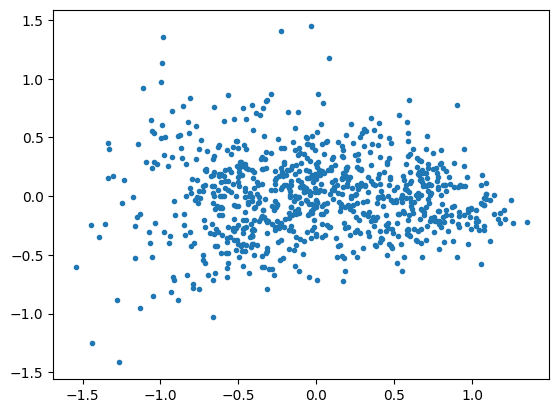

In [3]:
# check that embeddings look ok from a distance
dims = PCA(n_components=2).fit_transform(ds["embedding"])
plt.plot(dims[:, 0], dims[:, 1], ".")

# expectation: towards forming clusters, not big blob of points with a few outliers

In [34]:
# order the novels
years = [int(name[0:4]) for name in ds["novel"]]
ds_sorted = ds.add_column("year", years).sort("year")

# adding artist metadata
meta_lean = meta.rename(columns={"FILENAME": "novel"}).drop(columns=["Unnamed: 0"]).drop_duplicates(subset=["novel"])
df = ds_sorted.to_pandas()
df = df.merge(meta_lean, on="novel", how="inner")

In [48]:
# preparing for modeling

# embeddings – high dimensional vectors to be compared using cosine similarity
X_e = np.array(df["embedding"].tolist())

# histograms of embeddings – probability distributions to be compared using relative entropy
X_h = np.array([calc_vector_histogram(emb, bins=256) for emb in df["embedding"].tolist()])

### E1

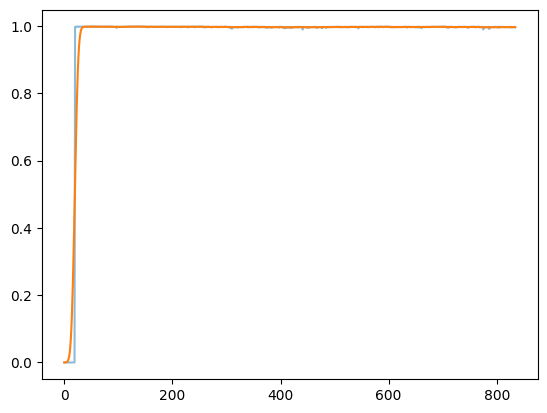

In [49]:
# check signal – cosine similarity with a reasonable window
ntr_cos_20 = WindowedRollingDistance(
    measure="cosine",
    window_size=20,
    ).fit(X_e)

plt.plot(ntr_cos_20.signal["N_hat"], alpha=0.5)
plt.plot(gaussian_filter1d(ntr_cos_20.signal["N_hat"], 5))

# expectation: not flat

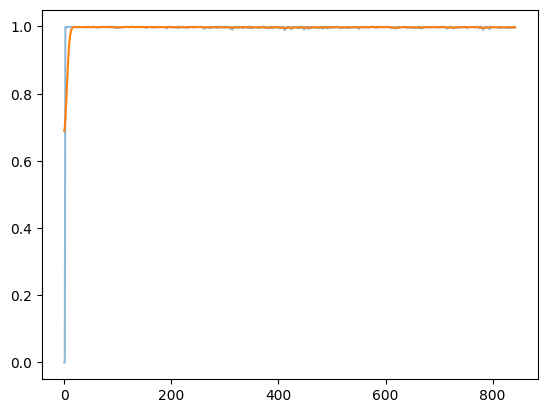

In [7]:
# check signal – cos sim in a very local context
ntr_cos_2 = WindowedRollingDistance(
    measure="cosine",
    window_size=2,
    ).fit(X_e)

plt.plot(ntr_cos_2.signal["N_hat"], alpha=0.5)
plt.plot(gaussian_filter1d(ntr_cos_2.signal["N_hat"], 5))

# expectation: more extreme than ntr_cos_20

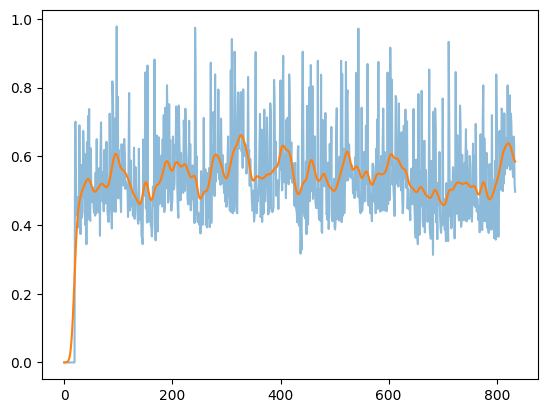

In [51]:
# check signal – entropy
ntr_jsd_20 = WindowedRollingDistance(
    measure="jensenshannon",
    window_size=20,
    ).fit(X_h)

plt.plot(ntr_jsd_20.signal["N_hat"], alpha=0.5)
plt.plot(gaussian_filter1d(ntr_jsd_20.signal["N_hat"], 5))

# expectation: somewhat similar to ntr_cos_20

### E2

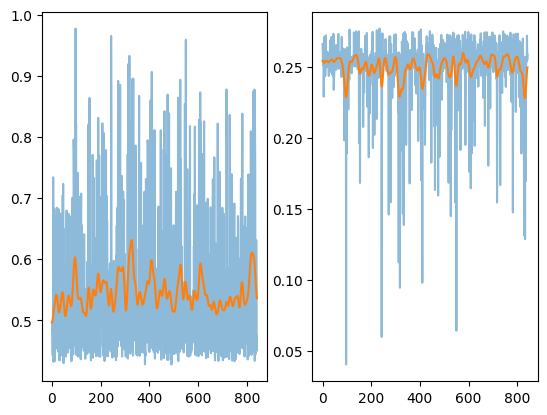

In [9]:
# comparing a book to all others
#   method: jensen-shannon distance between embedding_i and all other embeddings, then averaged (feel free to change to `cos_sim()`)
#   result: high avg distance & low uncertainity points are potentially interesting outliers
#   task: explain what they are

# distance to all
global_distances = []
for repr in X_h:
    d_glo = js_dist(repr, X_h)
    global_distances.append({
        "d_glo": d_glo,
        "d_glo_avg": d_glo.mean(),
        "d_glo_std": d_glo.std(),
    })

df_glo = pd.DataFrame(global_distances)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(df_glo["d_glo_avg"], alpha=0.5)
axs[0].plot(gaussian_filter1d(df_glo["d_glo_avg"], 5))

axs[1].plot(df_glo["d_glo_std"], alpha=0.5)
axs[1].plot(gaussian_filter1d(df_glo["d_glo_std"], 5))

/var/folders/9n/_b0__0295cs17prkkfjglwwd87mgrt/T/ipykernel_89798/3131556322.py:15: RuntimeWarning: Mean of empty slice.
  "d_past_avg": d_past.mean(),
/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/au582299/Repositories/memo-canonical-novels/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type

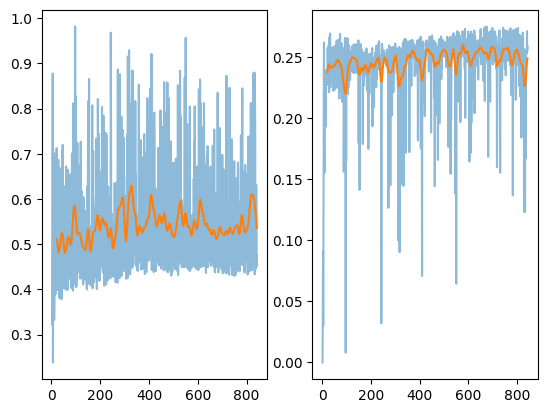

In [10]:
# comparing books to all preceeding books
#   method: jsd between embedding and all preceeding embeddings, averaged
#   result: it's stationary, which i didn't expect, otherwise it looks pretty similar to global distances
#   task: do we see the same outliers as with the global distances?

# distance to past
past_distances = []
for idx, repr in enumerate(X_h):
    w_start = 0
    w_end = np.max([idx - 1, 0])
    context_matrix = X_h[w_start : w_end]
    d_past = js_dist(repr, context_matrix)
    past_distances.append({
        "d_past": d_past,
        "d_past_avg": d_past.mean(),
        "d_past_std": d_past.std(),
    })

df_past = pd.DataFrame(past_distances)

fig, axs = plt.subplots(ncols=2)
axs[0].plot(df_past["d_past_avg"], alpha=0.5)
axs[0].plot(gaussian_filter1d(df_past["d_past_avg"], 5))

axs[1].plot(df_past["d_past_std"], alpha=0.5)
axs[1].plot(gaussian_filter1d(df_past["d_past_std"], 5))

### E3

removing paintings by louise  
– needs a bit more adjustment, i'm not sure if it works quite right

In [61]:
def calc_signals(ds, w_size):
    '''
    Calculate novelty, transience and resonance signals from image embeddings
    '''
    # convert embedding to array
    X = np.array(ds['embedding'])

    # convert array to probability distributions and back to array
    X_prob = [calc_vector_histogram(vect, bins=256) for vect in X]
    X_prob = np.array(X_prob)

    # calculate signal
    w_main = WindowedRollingDistance(
        measure='jensenshannon',
        window_size=w_size,
        estimate_error=True)

    signal = w_main.fit_transform(X_prob)

    # convert to dataframe
    signal_df = pd.DataFrame(signal)

    # add information about production year and artist
    # signal_df['year'] = ds['start_year']
    # signal_df['artist'] = ds['artist']

    return signal_df

def calc_signal_difference(no_artist_signal_df, org_signal, w_size):

    '''
    Calculate distance between two signals using Dynamic Time Warping
    '''

    # convert the novelty signal excluding a specific artist to a list
    n_df = no_artist_signal_df.iloc[w_size:, :]
    n_hat = n_df['N_hat'].tolist()

    # do the same for the original novelty signal
    n_df_original = org_signal.iloc[w_size:, :]
    n_hat_original = n_df_original['N_hat'].tolist()

    # calculate dtw (Dynamic Time Warping) difference
    dtw_score_n = dtw(n_hat, n_hat_original)

    # convert the resonance signal excluding a specific artist to a list
    r_df = no_artist_signal_df.iloc[w_size:-w_size, :]
    r_hat = r_df['R_hat'].tolist()

    # do the same for the original resonance signal
    r_df_original = org_signal.iloc[w_size:-w_size, :]
    r_hat_original = r_df_original['R_hat'].tolist()

    # calculate difference
    dtw_score_r = dtw(r_hat, r_hat_original)

    return dtw_score_n, dtw_score_r

def remove_random_paintings(org_signal, artist, random_state, ds, w_size):
    '''
    Iteratively sample n rows from a dataframe containing paintings from a specific artist, remove them from the total dataset
    and recalculate signals and Dynamic Time Warping differences.
    '''

    # initialize empty list
    dtws = []

    # filter df for given artist
    query_df = org_signal.query(f"AUTH_ID == '{artist}'")

    # iterate over the length of the query df
    for n in list(range(1, len(query_df))):

        # sample n amount of rows
        sample = query_df.sample(n, random_state=random_state)

        # remove these rows from the signal df
        df_paint_removed = org_signal.drop(list(sample.index))

        # select the remaining images from the huggingface dataset
        new_ds = ds.select(list(df_paint_removed.index))

        # recalculate novelty and resonance signals
        new_signal_df = calc_signals(new_ds, w_size)

        # recalculate Dynamic Time Warping distance for novelty
        dtw_n, _ = calc_signal_difference(new_signal_df, org_signal, w_size)

        dtws.append(dtw_n)

    return dtws

def remove_random_paintings_small_artists(org_signal, paintings_count, seed, ds, w_size):
    '''
    Sample n paintings by artists who have contributed less paintings than the specified paintings_count variable. 
    The sampled paintings are removed and novelty and resonance signals are recalculated along with a dynamic time warping distance 
    measure for each n.  
    '''

    # initialize empty list
    dtws = []
    
    # group artist by paintings count
    grouped = org_signal.groupby(['AUTH_ID'])['N_hat'].describe()
    grouped_df = grouped.reset_index() 

    # filter out artist with more paintings than the specified count
    small_artists = grouped_df.query(f'count <= {paintings_count}')
    small_artists = list(small_artists['AUTH_ID'])

    # only get rows(paintings) from these artists
    small_artists_df = org_signal[org_signal['AUTH_ID'].isin(small_artists)]

    # iterate over each value of n
    for n in list(range(1, len(small_artists_df))):

        # sample n rows
        sample = small_artists_df.sample(n, random_state=seed)

        # remove the sampled rows (paintings)
        df_paint_removed = org_signal.drop(list(sample.index))

        # create huggingface dataset where the sampled paintings are removed
        new_ds = ds.select(list(df_paint_removed.index))

        # recalculate signals
        new_signal_df = calc_signals(new_ds, w_size)

        # calculate dtw distance measure
        dtw_n, _ = calc_signal_difference(new_signal_df, org_signal, w_size)

        dtws.append(dtw_n)

    return dtws

In [58]:
SOME_SIGNAL = pd.DataFrame(ntr_jsd_20.signal)
df_sig = pd.concat([df, SOME_SIGNAL], axis=1)

In [62]:
results = []
for artist in list(set(df["AUTH_ID"])):
    result = remove_random_paintings(df_sig, artist, 2830, ds_sorted, 20)
    results.append(result)

small_results = remove_random_paintings_small_artists(df_sig, 2, 2830, ds, 20)

/var/folders/9n/_b0__0295cs17prkkfjglwwd87mgrt/T/ipykernel_89798/3831652774.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


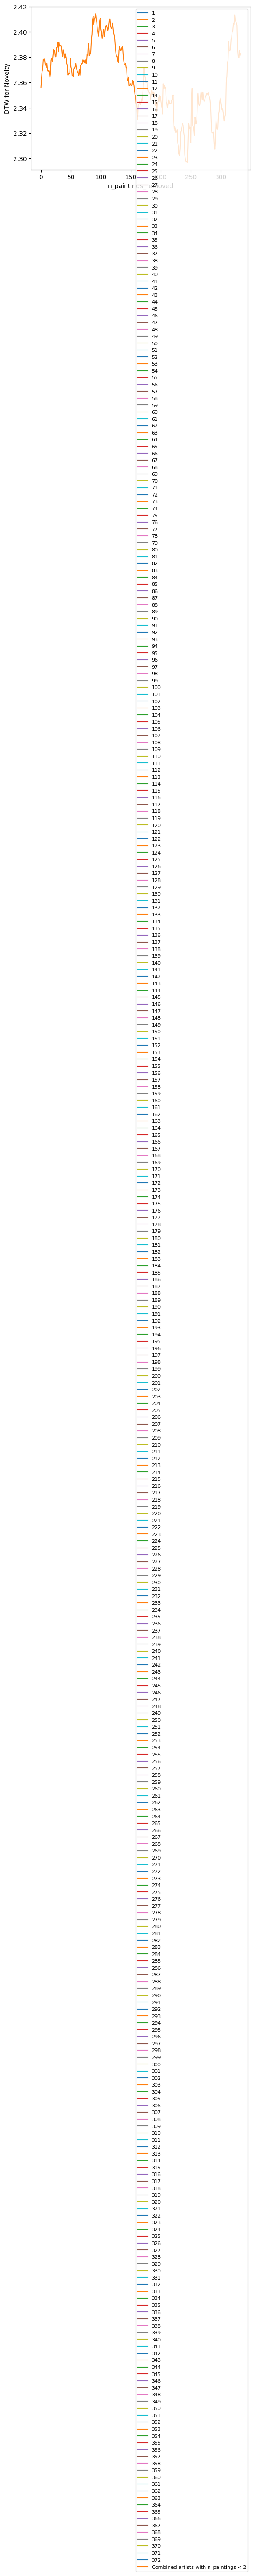

In [63]:
for i, v in enumerate(results):
    plt.plot(range(len(v)), v, label = list(set(df["AUTH_ID"]))[i])

plt.plot(range(len(small_results)), small_results, label = 'Combined artists with n_paintings < 2')
plt.ylabel('DTW for Novelty')
plt.xlabel('n_paintings_removed')
plt.legend(fontsize=8)
#plt.title('Dynamic Time Warping distance vs number of paintings removed')
plt.tight_layout()
plt.show()